In [1]:
from numpy import save, load
from pandas import read_csv

!pip install git+https://github.com/Zahlii/shap.git

import tensorflow as tf

import tensorflow.keras.backend as K


from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras import Model
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense,Activation
from keras.models import Input, Model
from keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,GlobalAveragePooling1D,TimeDistributed, MaxPooling1D

import numpy as np

import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple


tf.compat.v1.disable_v2_behavior()


  Cloning https://github.com/Zahlii/shap.git to /tmp/pip-req-build-ldkp8_qo
  Running command git clone --filter=blob:none --quiet https://github.com/Zahlii/shap.git /tmp/pip-req-build-ldkp8_qo
  Resolved https://github.com/Zahlii/shap.git to commit 28010d77f40141aaf8c69534f9c0878448cd1e49
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=505995 sha256=87c38cc640a7ed6d8efd5ab9939ffaaca9f6f31de036cca0fb55c9ee5fac62b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-zla_g1fv/wheels/8d/bd/18/2367d398d5137c8aae7180c0594b3d223be59507266386068c
Successfully built shap
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.41.0
    Uninstalling shap-0.41.0:
      Successfully uninstalled shap-0.41.0


In [2]:
from numpy import load
X_train = load('../input/dataset1/trainX.npy')
y_train = load('../input/dataset1/trainy.npy')
X_test = load('../input/dataset1/testX.npy')
y_test = load('../input/dataset1/testy.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(33104, 128, 6) (33104, 118) (3740, 128, 6) (3740, 118)


In [3]:
from sklearn.model_selection import train_test_split
X_train, x_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [4]:
def channel_normalization(x):
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out

def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    original_x = x
    conv = Convolution1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x

In [5]:
class TCN:

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding
        

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        if self.dilations is None:
            self.dilations = [1, 2, 4, 8, 16, 32]
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x

In [6]:
input_shape = X_train.shape[1:]
input = Input(shape=X_train.shape[1:])
x = SpatialDropout1D(0.2)(input)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc1')(x)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc2')(x)
x = K.max(x, axis=1, keepdims=True)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(118, activation="softmax")(x)    
model = Model(inputs=input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

2022-09-23 19:58:57.342503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 19:58:57.450068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 19:58:57.450943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 19:58:57.452539: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 6)]     0                                            
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 128, 6)       0           input_1[0][0]                    
__________________________________________________________________________________________________
tnc1_initial_conv (Conv1D)      (None, 128, 128)     896         spatial_dropout1d[0][0]          
__________________________________________________________________________________________________
tnc1_dilated_conv_1_tanh_s0 (Co (None, 128, 128)     49280       tnc1_initial_conv[0][0]          
______________________________________________________________________________________________

In [7]:
history = model.fit(X_train, y_train, epochs=200, verbose=True, validation_data=(x_validation, y_validation), batch_size=128,callbacks=callbacks)

Train on 26483 samples, validate on 6621 samples
Epoch 1/200


2022-09-23 19:59:03.306854: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


26483/26483 [==============================] - ETA: 0s - loss: 3.0358 - acc: 0.2878

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


26483/26483 [==============================] - 21s 776us/sample - loss: 3.0358 - acc: 0.2878 - val_loss: 0.9712 - val_acc: 0.7978
Epoch 2/200
26483/26483 [==============================] - 12s 443us/sample - loss: 0.9945 - acc: 0.7418 - val_loss: 0.3552 - val_acc: 0.9148
Epoch 3/200
26483/26483 [==============================] - 12s 442us/sample - loss: 0.5439 - acc: 0.8605 - val_loss: 0.2390 - val_acc: 0.9428
Epoch 4/200
26483/26483 [==============================] - 12s 443us/sample - loss: 0.3986 - acc: 0.8957 - val_loss: 0.1831 - val_acc: 0.9535
Epoch 5/200
26483/26483 [==============================] - 12s 443us/sample - loss: 0.3248 - acc: 0.9140 - val_loss: 0.1560 - val_acc: 0.9586
Epoch 6/200
26483/26483 [==============================] - 12s 444us/sample - loss: 0.2734 - acc: 0.9284 - val_loss: 0.1336 - val_acc: 0.9683
Epoch 7/200
26483/26483 [==============================] - 12s 446us/sample - loss: 0.2439 - acc: 0.9339 - val_loss: 0.1314 - val_acc: 0.9650
Epoch 8/200
26483/

In [15]:
model.save_weights("XAI(SHAP)-TCN-D1.h5")

In [18]:
loss, accuracy = model.evaluate(x_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9795
Testing Accuracy: 0.9241


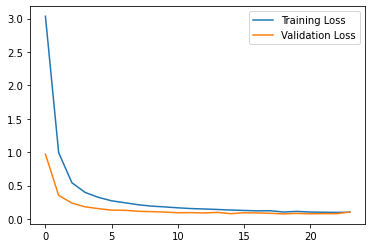

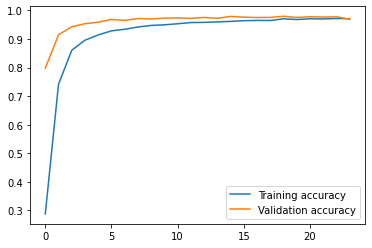

In [19]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history["acc"], label="Training accuracy")
plt.plot(history.history["val_acc"], label="Validation accuracy")
plt.legend()
plt.show()


In [20]:
import shap

explainer = shap.DeepExplainer(model, X_train[:100])

shap_values = explainer.shap_values(X_test[:100], check_additivity=False)

In [ ]:
shap.initjs()
import numpy as np

#shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[0])

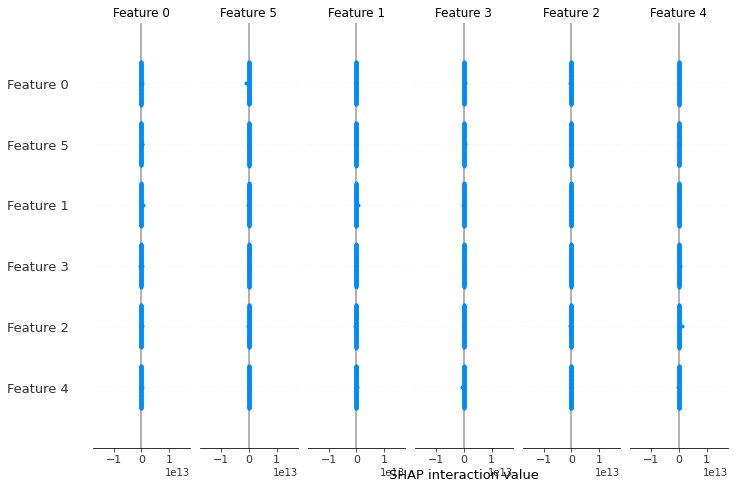

In [22]:
shap.summary_plot(shap_values[0], plot_type = 'bar')

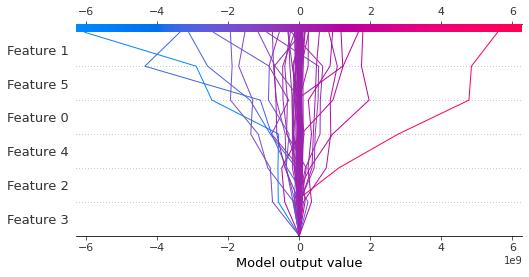

In [23]:
shap.decision_plot(explainer.expected_value[0], shap_values[0][0], features = X_test[0,:])

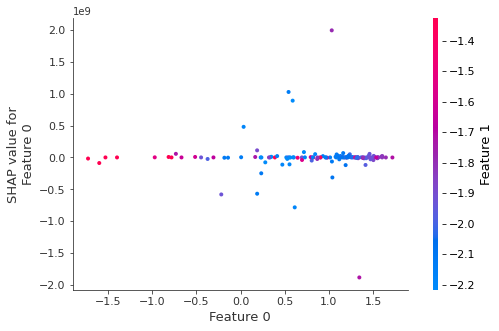

In [24]:
shap.dependence_plot('Feature 0', shap_values[0][0], X_train[0], interaction_index="Feature 1")

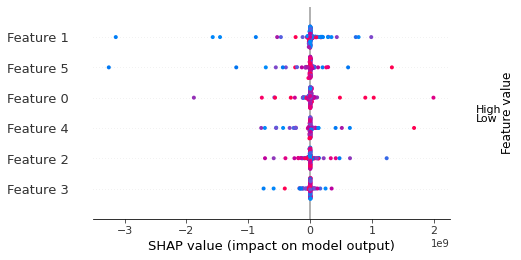

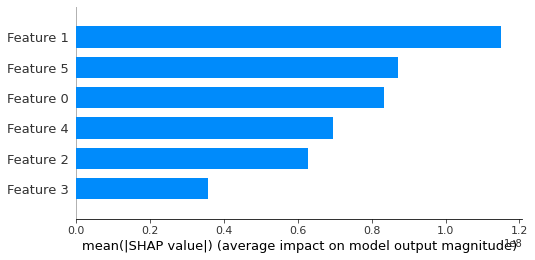

In [25]:
shap.summary_plot(shap_values[0][0], X_test[0],title="SHAP summary plot") 

# Generate summary bar plot 
shap.summary_plot(shap_values[0][0], X_test[0],plot_type="bar")